

| EDA dataframe      | Description |due|
| ----------- | ----------- |----------- |
| grape_df  | 캠벨얼리 가격/거래량  |20190101 ~ 20201104|
| df      | grape_train + shinemuscat_train       | 20190101 ~ 2020928|


**train accuracy / test accuracy 의 차이 비교 overfitting = 20% 이상 (10~20%)**

https://dacon.io/competitions/official/235801/codeshare/4063?page=1&dtype=recent

[lgbm 튜닝](https://dacon.io/competitions/official/235698/talkboard/404322)

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic'

from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib as mpl
from IPython.core.display import display, HTML
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import urllib.request
import requests
import json
import datetime
import os
from datetime import datetime
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

/var/folders/lm/z4n_2b8s6rj3_vv57sg789kc0000gn/T/ipykernel_75142/2031877544.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [4]:
# iMAC

raw_path = '/Users/cge/Documents/yeardream/project/kurly/products_price_predict/data/raw/'
processed_path = '/Users/cge/Documents/yeardream/project/kurly/products_price_predict/data/processed/'

In [5]:
# Macbook
    
# raw_path = '/Users/goeun/Documents/YearDream/ProJect/kurly_project/products_price_predict/data/raw/'
# processed_path = '/Users/goeun/Documents/YearDream/ProJect/kurly_project/products_price_predict/data/processed/'

In [13]:
grape = pd.read_csv(processed_path+'캠벨얼리_전처리후.csv')
mushroom = pd.read_csv(processed_path+'팽이버섯_전처리후.csv')
tomato = pd.read_csv(processed_path+'토마토_전처리후.csv')
welsh = pd.read_csv(processed_path+'대파_전처리후.csv')
plant = pd.read_csv(processed_path+'깻잎_전처리후.csv')

private = pd.read_csv(raw_path+'private_data.csv')
submission = pd.read_csv(raw_path+'sample_submission.csv')

print(grape.shape)
print(mushroom.shape)
print(private.shape)
print(submission.shape)

(1770, 9)
(1770, 9)
(1770, 15)
(291, 44)
(228, 22)


In [15]:
tomato.drop(columns=['요일_0','요일_1', '요일_2', '요일_3', '요일_4', '요일_5', '요일_6'], inplace=True)
welsh.drop(columns=['요일_0','요일_1', '요일_2', '요일_3', '요일_4', '요일_5', '요일_6'], inplace=True)
plant.drop(columns=['요일_0','요일_1', '요일_2', '요일_3', '요일_4', '요일_5', '요일_6'], inplace=True)

In [22]:
df = pd.merge(grape, mushroom, on=['date', '요일','계절'])
df = pd.merge(df, tomato, on =['date', '계절'] )
df = pd.merge(df, welsh, on = ['date','계절'])
df = pd.merge(df, plant, on = ['date','계절'])

train = df[:1733]
test = df[1733:]

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1733 entries, 0 to 1732
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              1733 non-null   object 
 1   요일                1733 non-null   object 
 2   캠벨얼리_거래량(kg)      1733 non-null   float64
 3   캠벨얼리_가격(원/kg)     1733 non-null   float64
 4   캠벨얼리_거래량의_1주전_평균  1733 non-null   float64
 5   캠벨얼리_가격의_1주전_평균   1733 non-null   float64
 6   캠벨얼리_거래량의_2주전_평균  1733 non-null   float64
 7   캠벨얼리_가격의_2주전_평균   1733 non-null   float64
 8   계절                1733 non-null   int64  
 9   팽이버섯_거래량(kg)      1733 non-null   float64
 10  팽이버섯_가격(원/kg)     1733 non-null   float64
 11  팽이버섯_거래량의_1주전_평균  1733 non-null   float64
 12  팽이버섯_가격의_1주전_평균   1733 non-null   float64
 13  팽이버섯_거래량의_2주전_평균  1733 non-null   float64
 14  팽이버섯_가격의_2주전_평균   1733 non-null   float64
 15  토마토_거래량(kg)       1733 non-null   float64
 16  토마토_가격(원/kg)      1733 non-null   float64


# LGBM(LightGBM)

## 대파 & 깻잎 & 팽이버섯 & 토마토 & 캠벨얼리

In [26]:
private2 = private.copy()
private2 = private2[['date','대파_거래량(kg)', '대파_가격(원/kg)', '깻잎_거래량(kg)', '깻잎_가격(원/kg)',
               '팽이버섯_거래량(kg)', '팽이버섯_가격(원/kg)', '토마토_거래량(kg)', '토마토_가격(원/kg)', '캠벨얼리_거래량(kg)', '캠벨얼리_가격(원/kg)',]]

In [27]:
private2['date'] = private2.date.astype(str).str.replace('-','')
private2['date'] = pd.to_datetime(private2.date, format='%Y%m%d')


t = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']
private2['요일'] = 0
temp = []
for i in range(len(private2)):
      temp.append(t[int(private2['date'][i].weekday())])
private2['요일'] = temp

private2 = private2[['date', '요일','대파_거래량(kg)', '대파_가격(원/kg)', '깻잎_거래량(kg)', '깻잎_가격(원/kg)',
               '팽이버섯_거래량(kg)', '팽이버섯_가격(원/kg)', '토마토_거래량(kg)', '토마토_가격(원/kg)', '캠벨얼리_거래량(kg)', '캠벨얼리_가격(원/kg)',]]

In [29]:
class Nong1:
    

  def __init__(self, df, test):
    self.df = df
    self.test = test
    self.df = pd.concat([self.df, self.test], axis=0).reset_index(drop=True)
    self.df = self.df[1:].replace(0, np.NaN)
    self.df = self.df.interpolate().fillna(0)
    self.df.date = pd.to_datetime(self.df.date)
    self.df = pd.concat([self.df, pd.get_dummies(self.df['요일'])], axis=1)
    self.feature = self.df.columns[2:]
    self.df = self.df.reset_index(drop=True)

  def set_feature(self,name):
    self.name = name
    self.name1 = name+ "_가격(원/kg)"
    self.name2 = name+ "_거래량(kg)"
    self.name3 = name+ "_거래량의_1주전_평균"
    self.name4 = name+ '_가격의_1주전_평균'
    self.name5 = name+ '_거래량의_2주전_평균'
    self.name6 = name+ '_가격의_2주전_평균'
    self.name7 = '계절'
    self.feature = [self.name1, self.name2, self.name3, self.name4, self.name5, self.name6, self.name7, '금요일',   '목요일',   '수요일',   '월요일',   '일요일',   '토요일',   '화요일', 'resid']

  def set_target(self,week):
    if week == 1:
      self.df['target'] = self.df[self.name1].shift(-8)
    elif week == 2:
      self.df['target'] = self.df[self.name1].shift(-15)
    elif week == 4:
      self.df['target'] = self.df[self.name1].shift(-29)
    
    self.df['resid'] = 0
    stl = STL(self.df[['date', self.name1]].set_index('date'), period=12)
    res = stl.fit()
    self.df['resid'] = res.resid.values

  def set_model_lgb(self):
    import lightgbm as lgb
    self.scaler = RobustScaler()
    self.df[self.feature] = self.scaler.fit_transform(self.df[self.feature])
    self.df_learn = self.df[self.df['target'].notnull()]
    self.X = self.df_learn[self.feature]
    self.y = self.df_learn['target']
    
    self.train_split = 1733
    self.valid_split = 1770
    
    self.X_train = self.X[:self.train_split]
    self.y_train = self.y[:self.train_split]
    self.X_valid = self.X[self.train_split:self.valid_split]
    self.y_valid = self.y[self.train_split:self.valid_split]
    self.X_test = self.X[self.valid_split:]
    self.y_test = self.y[self.valid_split:]

    self.train_ds = lgb.Dataset(self.X_train,  label = self.y_train)
    self.valid_df = lgb.Dataset(self.X_valid,  label = self.y_valid)

#     self.params= {
#                 'num_leaves':10000 ,
#                 'objective' :'regression',
#                 'metric':'mse'
#                 } 
    self.params = {'learning_rate': 0.01, 
          'max_depth': 6, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mse', 
          'is_training_metric': True, 
          'num_leaves': 100, 
          'feature_fraction': 0.8, 
          'bagging_fraction': 0.8, 
          'bagging_freq': 5, 
          'num_threads':8
             }
    self.num_round = 1000
    
    self.model_lgb = lgb.train(self.params, self.train_ds, self.num_round, self.valid_df)

  def get_plot_lgb(self):  
    self.y_pred = self.model_lgb.predict(self.X_test)
    self.RMSE = mean_squared_error(self.y_test, self.y_pred) ** 0.5

    plt.figure(figsize=(20, 10), dpi=300)
    plt.title(self.name + ' 가격 예측 결과'+   '   RMSE : ' + str(self.RMSE)[:7])
    plt.ylabel(self.name + ' 가격')
    plt.plot(np.array(self.y_train), alpha = 0.9, label = 'Real')
    plt.plot(self.model_lgb.predict(self.X_train), alpha = 0.6, linestyle = "--", label = 'Predict')
    plt.legend()
    plt.show()
    self.RMSE.round(2)

  def get_price_lgb(self):
    # self.X_test = X_test[self.feature]
    self.price = self.model_lgb.predict(self.X_test)
    return self.price[0]

In [30]:
my_nong1 = Nong1(df, private2)

my_nong1.set_feature('토마토')

my_nong1.set_target(1)

In [31]:
my_nong1.set_model_lgb()

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1872
[LightGBM] [Info] Number of data points in the train set: 1733, number of used features: 15
[LightGBM] [Info] Start training from score 2176.669648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l2: 74478.2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's l2: 74048.1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's l2: 73541.5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's l2: 73118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's l2: 72692.3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's l2: 72366.1
[LightGBM] [Warning] No further splits with posit

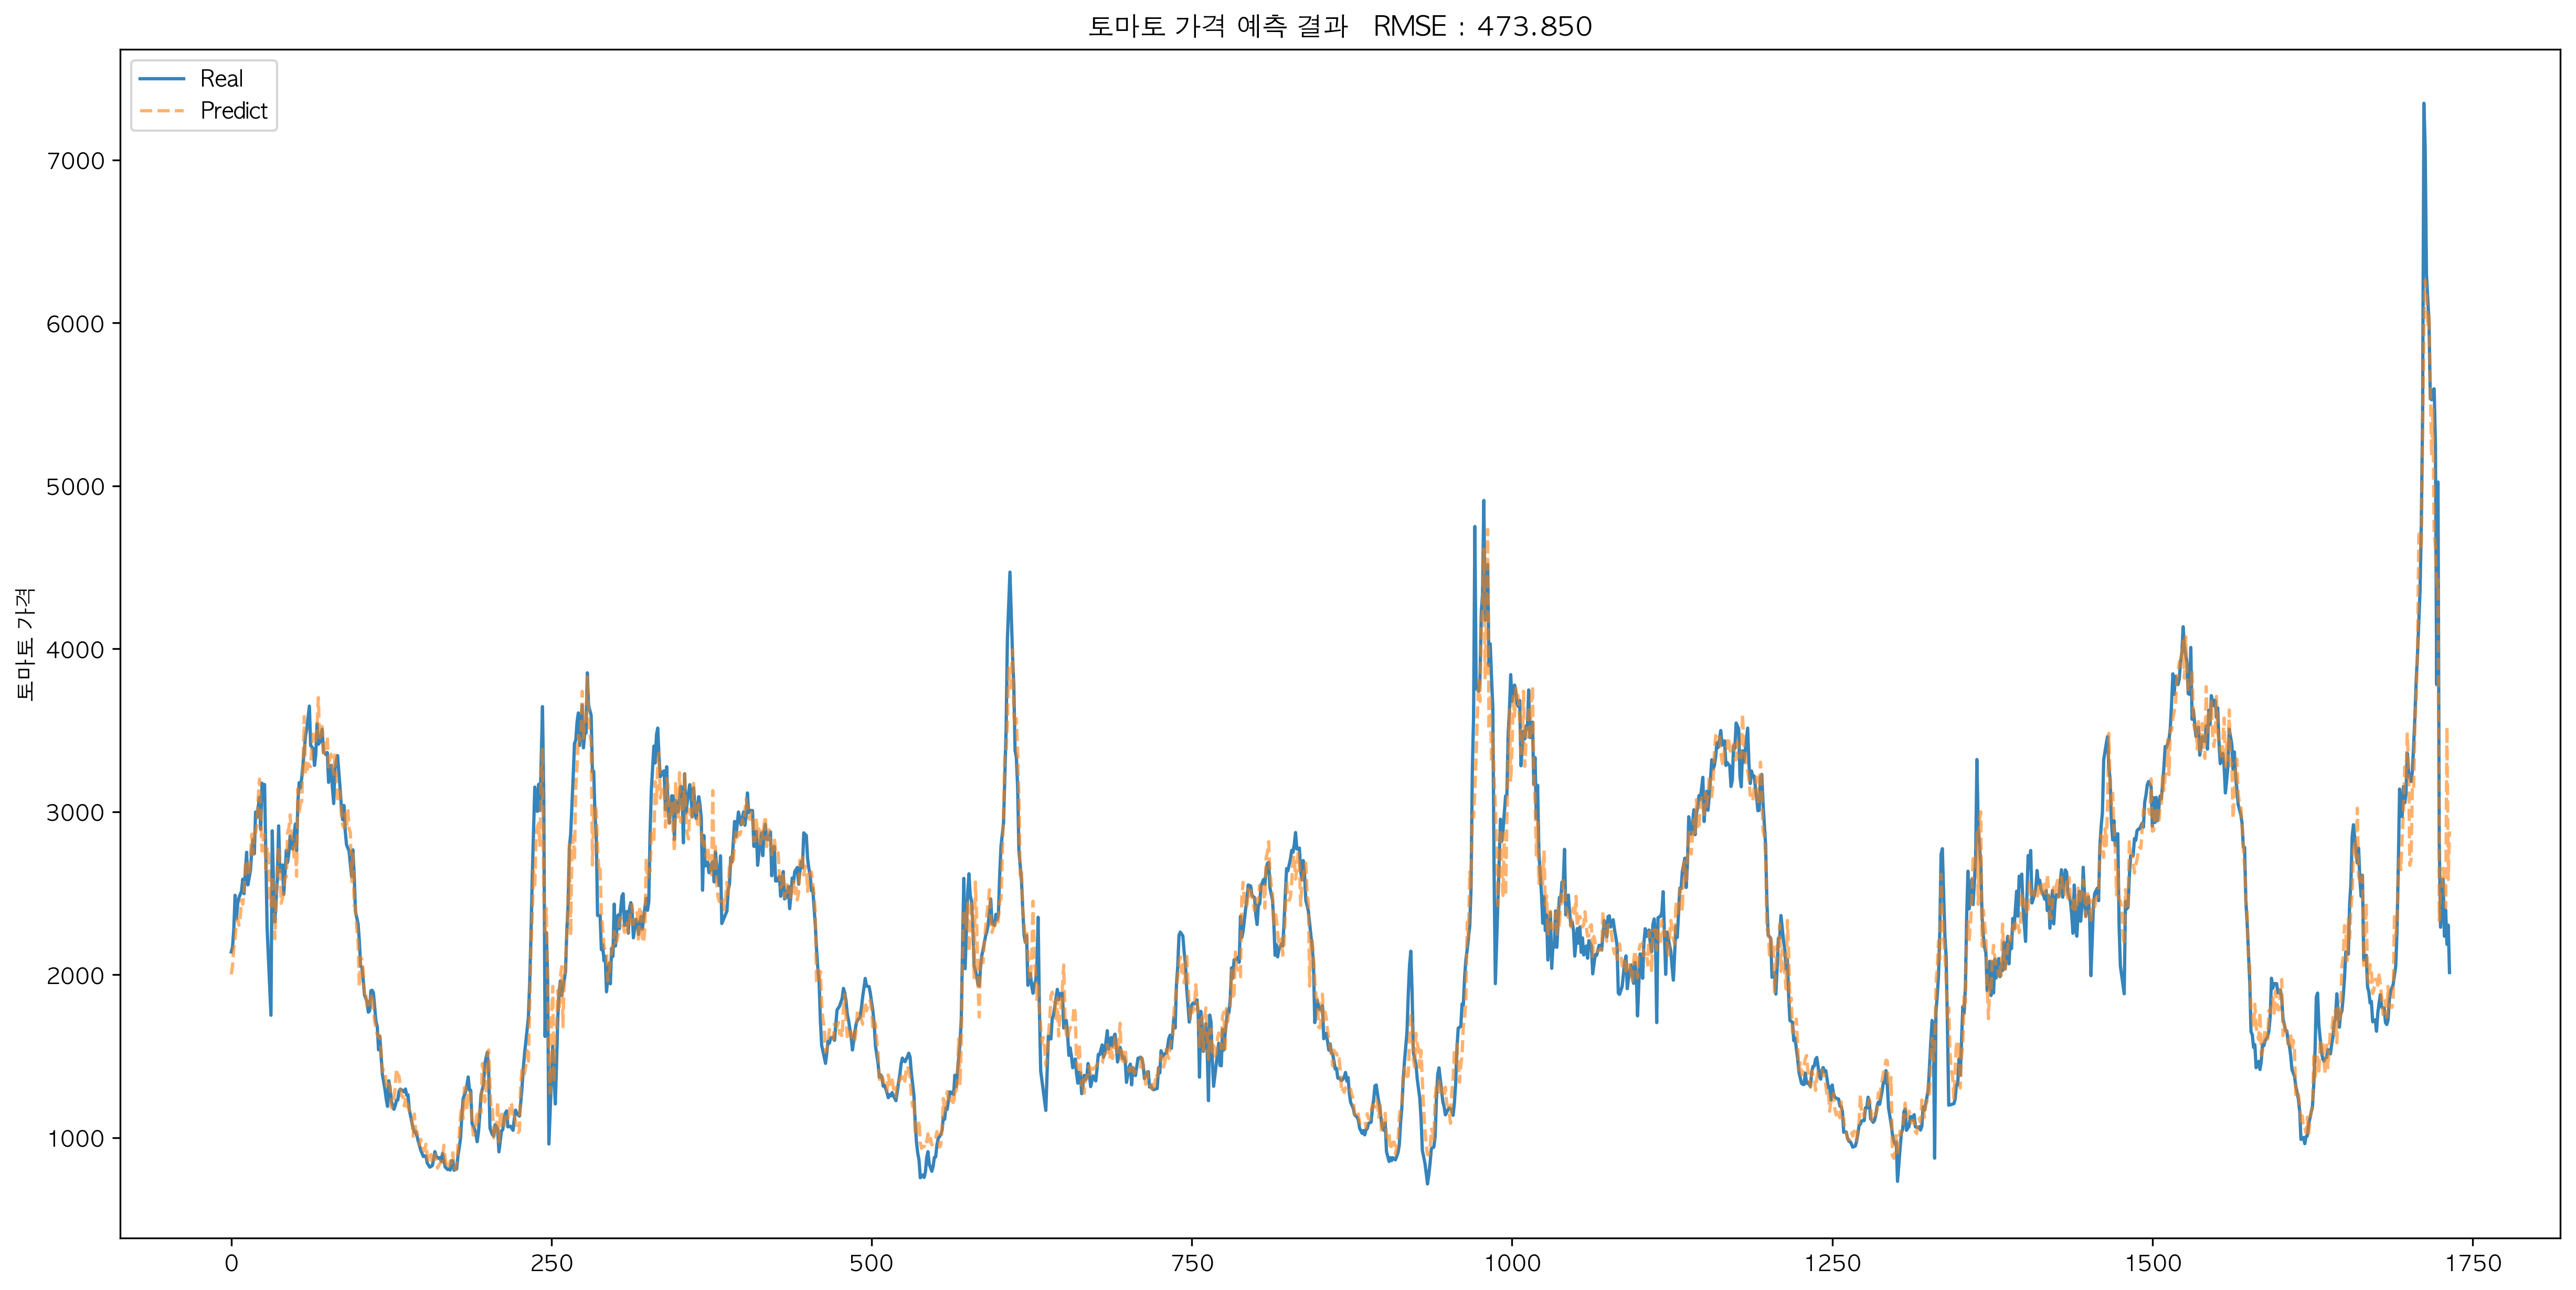

In [32]:
my_nong1.get_plot_lgb()

### 모델 실행


In [33]:
from sympy import Shi


weeks = [1, 2, 4]
features = ['대파', '깻잎', '팽이버섯', '토마토', '캠벨얼리'] 

week1=[]
week2=[]
week4=[]

for week in weeks:
  print(week)
  for feature in features:
    my_nong1 = Nong1(df, private2)
    my_nong1.set_feature(feature)
    my_nong1.set_target(week)
    print(my_nong1.set_target(week))
    my_nong1.set_model_lgb()
    if week == 1:
      week1.append(my_nong1.get_price_lgb())
    if week == 2:
      week2.append(my_nong1.get_price_lgb())
    if week == 4:
      week4.append(my_nong1.get_price_lgb())
    print(feature)

1
None
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1872
[LightGBM] [Info] Number of data points in the train set: 1733, number of used features: 15
[LightGBM] [Info] Start training from score 1365.433930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l2: 368199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's l2: 362019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's l2: 356397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's l2: 350469
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's l2: 344078
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's l2: 338649
[LightGBM] [Warning] No further splits with po

In [34]:
week1, week2, week4

([1759.0212300275857,
  5885.053852308494,
  1428.2046041786555,
  1818.9505470704664,
  4027.5705253058277],
 [1778.6409392877786,
  5123.3023925714715,
  1636.1310234437428,
  2152.550452931299,
  4305.205154240988],
 [1782.094329070148,
  5611.6918607868465,
  1547.3622376992478,
  2419.562981518221,
  3669.499877442395])

In [35]:
from pyrsistent import b


date = '20201106'

feature = [ '대파_가격(원/kg)', '깻잎_가격(원/kg)','팽이버섯_가격(원/kg)', '토마토_가격(원/kg)', '캠벨얼리_가격(원/kg)']
submission = submission.set_index('예측대상일자')
submission.loc[datetime.strptime(date, "%Y%m%d").strftime("%Y-%m-%d")+'+1week', feature] = week1
submission.loc[datetime.strptime(date, "%Y%m%d").strftime("%Y-%m-%d")+'+2week', feature] = week2
submission.loc[datetime.strptime(date, "%Y%m%d").strftime("%Y-%m-%d")+'+4week', feature] = week4
submission.reset_index(drop=False, inplace=True)
title = 'submission' + date + '.csv'

In [36]:
submission.drop(columns=['배추_가격(원/kg)', '무_가격(원/kg)', '양파_가격(원/kg)', '건고추_가격(원/kg)',
       '마늘_가격(원/kg)',  '얼갈이배추_가격(원/kg)', '양배추_가격(원/kg)',
       '시금치_가격(원/kg)', '미나리_가격(원/kg)', '당근_가격(원/kg)', '파프리카_가격(원/kg)', '새송이_가격(원/kg)', 
       '청상추_가격(원/kg)', '백다다기_가격(원/kg)', '애호박_가격(원/kg)','샤인마스캇_가격(원/kg)'], inplace= True)

In [41]:
submission2 = submission[228:].round(2)
submission2

,예측대상일자,대파_가격(원/kg),깻잎_가격(원/kg),팽이버섯_가격(원/kg),토마토_가격(원/kg),캠벨얼리_가격(원/kg)
228,2020-11-06+1week,1759.02,5885.05,1428.20,1818.95,4027.57
229,2020-11-06+2week,1778.64,5123.30,1636.13,2152.55,4305.21
230,2020-11-06+4week,1782.09,5611.69,1547.36,2419.56,3669.50


In [42]:
# 실제값과 비교! 
private2 = private2[['date','요일','대파_가격(원/kg)', '깻잎_가격(원/kg)','팽이버섯_가격(원/kg)', '토마토_가격(원/kg)', '캠벨얼리_가격(원/kg)']]
private2_week = private2[::7]
private2_week[1:5]

,date,요일,대파_가격(원/kg),깻잎_가격(원/kg),팽이버섯_가격(원/kg),토마토_가격(원/kg),캠벨얼리_가격(원/kg)
7,2020-11-13,금요일,2374.0,5013.0,1532.0,2305.0,3579.0
14,2020-11-20,금요일,2319.0,3316.0,1471.0,2015.0,4859.0
21,2020-11-27,금요일,1841.0,3129.0,1294.0,1847.0,4353.0
28,2020-12-04,금요일,1543.0,4326.0,1255.0,1814.0,4063.0


In [43]:
submission2.to_csv(processed_path + title, encoding='utf-8-sig', index = False)